In [259]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import numpy as np
import gradio as gr
import seaborn as sns
import time


#regression
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression, Ridge, BayesianRidge, HuberRegressor, Lasso
from sklearn.metrics import make_scorer, mean_squared_error,confusion_matrix,accuracy_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR  
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV 

In [260]:
def readdata(filename):
    return pd.read_csv(filename)

train_data=readdata("Dataset/FP_Data_Train.csv")
test_data=readdata("Dataset/FP_Test_set.csv")

In [261]:
price_of_test_data=readdata('Dataset/FP_Sample_submission.csv')

In [262]:
price_of_test_data=pd.DataFrame(price_of_test_data)
price_of_test_data

,Price
0,15998
1,16612
2,25572
3,25778
4,16934
...,...
2666,14046
2667,14086
2668,22720
2669,23544


In [263]:
train_data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [264]:
# resmoving NaN rows
train_data.dropna(inplace=True)
train_data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [265]:
train_data=train_data.drop(columns=['Route','Additional_Info'])

train_data['Date_of_Journey']=pd.to_datetime(train_data['Date_of_Journey'],infer_datetime_format=True)
train_data.sort_values(['Date_of_Journey'],inplace=True, ascending=True)
train_data=train_data.reset_index(drop=True)

### Data Cleaning And Preprocessing Of Train Data

In [266]:
train_data

,Airline,Date_of_Journey,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price
0,SpiceJet,2019-03-01,Chennai,Kolkata,09:30,12:05,2h 35m,non-stop,7298
1,Air India,2019-03-01,Banglore,New Delhi,11:05,22:10,11h 5m,2 stops,13576
2,Vistara,2019-03-01,Banglore,New Delhi,06:40,10:25 02 Mar,27h 45m,1 stop,12371
3,IndiGo,2019-03-01,Kolkata,Banglore,20:25,23:05,2h 40m,non-stop,4778
4,Air India,2019-03-01,Banglore,New Delhi,09:30,23:45,14h 15m,1 stop,12704
...,...,...,...,...,...,...,...,...,...
10677,Jet Airways,2019-06-27,Delhi,Cochin,19:45,12:35 28 Jun,16h 50m,1 stop,10262
10678,Air India,2019-06-27,Banglore,Delhi,10:00,12:45,2h 45m,non-stop,6961
10679,Jet Airways,2019-06-27,Delhi,Cochin,10:00,19:00,9h,1 stop,14714
10680,Multiple carriers,2019-06-27,Delhi,Cochin,08:45,19:15,10h 30m,1 stop,8266


In [267]:
# Creatng date month columns from data of journey
def Journey_date(data):
    journey_day=pd.to_datetime(data['Date_of_Journey']).dt.day
    journey_month=pd.to_datetime(data['Date_of_Journey']).dt.month
    data.drop('Date_of_Journey',axis=1,inplace=True)
    return journey_day ,journey_month

train_data['Journey_day'],train_data['Journey_month']=Journey_date(train_data)
train_data

,Airline,Source,Destination,Dep_Time,Arrival_Time,Duration,Total_Stops,Price,Journey_day,Journey_month
0,SpiceJet,Chennai,Kolkata,09:30,12:05,2h 35m,non-stop,7298,1,3
1,Air India,Banglore,New Delhi,11:05,22:10,11h 5m,2 stops,13576,1,3
2,Vistara,Banglore,New Delhi,06:40,10:25 02 Mar,27h 45m,1 stop,12371,1,3
3,IndiGo,Kolkata,Banglore,20:25,23:05,2h 40m,non-stop,4778,1,3
4,Air India,Banglore,New Delhi,09:30,23:45,14h 15m,1 stop,12704,1,3
...,...,...,...,...,...,...,...,...,...,...
10677,Jet Airways,Delhi,Cochin,19:45,12:35 28 Jun,16h 50m,1 stop,10262,27,6
10678,Air India,Banglore,Delhi,10:00,12:45,2h 45m,non-stop,6961,27,6
10679,Jet Airways,Delhi,Cochin,10:00,19:00,9h,1 stop,14714,27,6
10680,Multiple carriers,Delhi,Cochin,08:45,19:15,10h 30m,1 stop,8266,27,6


In [268]:
# Creatng date month columns from data of journey
def journey_time(data):
    arrival_hour=pd.to_datetime(data['Arrival_Time']).dt.hour
    arrival_mint=pd.to_datetime(data['Arrival_Time']).dt.minute
    data.drop('Arrival_Time',axis=1,inplace=True)
    
    dep_hour=pd.to_datetime(data['Dep_Time']).dt.hour
    dep_mint=pd.to_datetime(data['Dep_Time']).dt.minute
    data.drop('Dep_Time',axis=1,inplace=True)
    return arrival_hour,arrival_mint,dep_hour,dep_mint

train_data['Arrival_hour'],train_data['Arrival_mint'],train_data['Dep_hour'],train_data['Dep_mint']=journey_time(train_data)
train_data

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_day,Journey_month,Arrival_hour,Arrival_mint,Dep_hour,Dep_mint
0,SpiceJet,Chennai,Kolkata,2h 35m,non-stop,7298,1,3,12,5,9,30
1,Air India,Banglore,New Delhi,11h 5m,2 stops,13576,1,3,22,10,11,5
2,Vistara,Banglore,New Delhi,27h 45m,1 stop,12371,1,3,10,25,6,40
3,IndiGo,Kolkata,Banglore,2h 40m,non-stop,4778,1,3,23,5,20,25
4,Air India,Banglore,New Delhi,14h 15m,1 stop,12704,1,3,23,45,9,30
...,...,...,...,...,...,...,...,...,...,...,...,...
10677,Jet Airways,Delhi,Cochin,16h 50m,1 stop,10262,27,6,12,35,19,45
10678,Air India,Banglore,Delhi,2h 45m,non-stop,6961,27,6,12,45,10,0
10679,Jet Airways,Delhi,Cochin,9h,1 stop,14714,27,6,19,0,10,0
10680,Multiple carriers,Delhi,Cochin,10h 30m,1 stop,8266,27,6,19,15,8,45


In [269]:
# labling stops
def stops(data):
    dic={
        'non-stop':0,
        '1 stop':1,
        '2 stops':2,
        '3 stops':3,
        '4 stops':4
    }
    data['Total_Stops']=data['Total_Stops'].map(dic).tolist()
    return data

train_data=stops(train_data)
train_data

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_day,Journey_month,Arrival_hour,Arrival_mint,Dep_hour,Dep_mint
0,SpiceJet,Chennai,Kolkata,2h 35m,0,7298,1,3,12,5,9,30
1,Air India,Banglore,New Delhi,11h 5m,2,13576,1,3,22,10,11,5
2,Vistara,Banglore,New Delhi,27h 45m,1,12371,1,3,10,25,6,40
3,IndiGo,Kolkata,Banglore,2h 40m,0,4778,1,3,23,5,20,25
4,Air India,Banglore,New Delhi,14h 15m,1,12704,1,3,23,45,9,30
...,...,...,...,...,...,...,...,...,...,...,...,...
10677,Jet Airways,Delhi,Cochin,16h 50m,1,10262,27,6,12,35,19,45
10678,Air India,Banglore,Delhi,2h 45m,0,6961,27,6,12,45,10,0
10679,Jet Airways,Delhi,Cochin,9h,1,14714,27,6,19,0,10,0
10680,Multiple carriers,Delhi,Cochin,10h 30m,1,8266,27,6,19,15,8,45


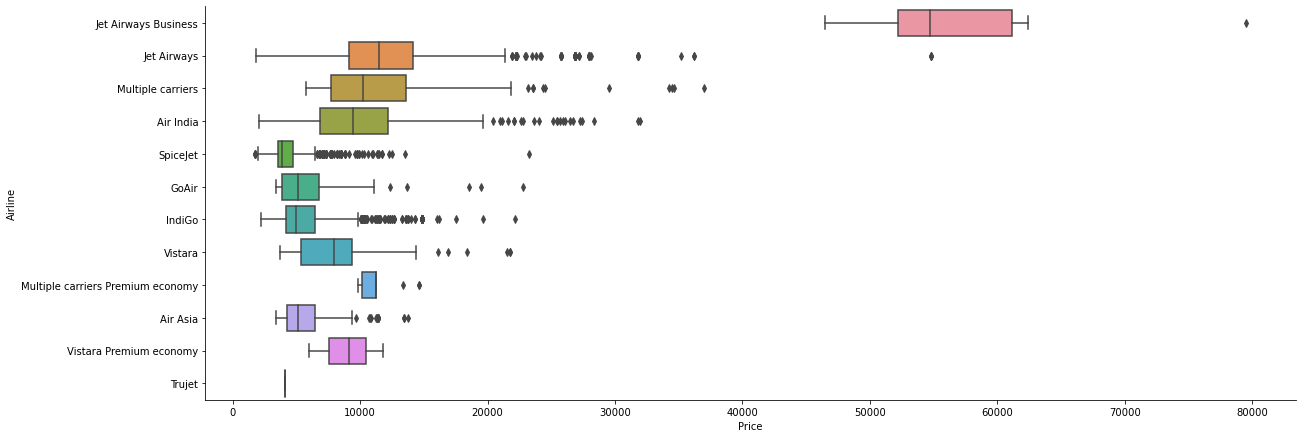

In [270]:
sns.catplot(x='Price',y='Airline' , data=train_data.sort_values(['Price'],ascending=False), kind="box",height = 6, aspect = 3)
plt.show()

In [271]:
#deducing running time into columns
def Runtime(data):
   
    data['Duration']=pd.to_timedelta(data['Duration'])  #convert string into timedelta
    data['Duration']=data['Duration'].dt.total_seconds().astype(int)
   
    run_day=[]
    run_hour=[]
    run_mint=[]
    for i in range(0,len(data['Duration'])):
       
        
        ty_res = time.gmtime(data['Duration'][i])
        res = time.strftime("%D %H:%M:%S",ty_res)
     
        res=pd.to_datetime(res,infer_datetime_format=True) #timestamp
       
        
        run_day.append(res.day-1) # -1 beacause time stamp by default start from 01/01/70 when a day increase after converting the seconds it get increased by 1 day
        run_hour.append(res.hour)
        run_mint.append(res.minute)
    
    data.drop('Duration',axis=1,inplace=True)
    return run_day,run_hour,run_mint


train_data['Run_day'],train_data['Run_hour'],train_data['Run_mint']=Runtime(train_data)
train_data

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Arrival_hour,Arrival_mint,Dep_hour,Dep_mint,Run_day,Run_hour,Run_mint
0,SpiceJet,Chennai,Kolkata,0,7298,1,3,12,5,9,30,0,2,35
1,Air India,Banglore,New Delhi,2,13576,1,3,22,10,11,5,0,11,5
2,Vistara,Banglore,New Delhi,1,12371,1,3,10,25,6,40,1,3,45
3,IndiGo,Kolkata,Banglore,0,4778,1,3,23,5,20,25,0,2,40
4,Air India,Banglore,New Delhi,1,12704,1,3,23,45,9,30,0,14,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,Jet Airways,Delhi,Cochin,1,10262,27,6,12,35,19,45,0,16,50
10678,Air India,Banglore,Delhi,0,6961,27,6,12,45,10,0,0,2,45
10679,Jet Airways,Delhi,Cochin,1,14714,27,6,19,0,10,0,0,9,0
10680,Multiple carriers,Delhi,Cochin,1,8266,27,6,19,15,8,45,0,10,30


In [272]:
#train_data['Source']=train_data['Source'].map(lambda x: 'New Delhi' if x=='Delhi' else ( None))
#train_data

#ye v kr dena ye mujese nhi ho rh hai


In [273]:
pro_train_data=pd.get_dummies(train_data)

In [274]:
pd.set_option('max_columns', 34)
pro_train_data.astype(int)

,Total_Stops,Price,Journey_day,Journey_month,Arrival_hour,Arrival_mint,Dep_hour,Dep_mint,Run_day,Run_hour,Run_mint,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,7298,1,3,12,5,9,30,0,2,35,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0
1,2,13576,1,3,22,10,11,5,0,11,5,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,12371,1,3,10,25,6,40,1,3,45,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
3,0,4778,1,3,23,5,20,25,0,2,40,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
4,1,12704,1,3,23,45,9,30,0,14,15,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,1,10262,27,6,12,35,19,45,0,16,50,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
10678,0,6961,27,6,12,45,10,0,0,2,45,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
10679,1,14714,27,6,19,0,10,0,0,9,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
10680,1,8266,27,6,19,15,8,45,0,10,30,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [275]:
pro_train_data.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Arrival_hour',
       'Arrival_mint', 'Dep_hour', 'Dep_mint', 'Run_day', 'Run_hour',
       'Run_mint', 'Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai', 'Destination_Banglore', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi'],
      dtype='object')

In [276]:
#arranging columns
pro_train_data=pro_train_data[['Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy','Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai','Destination_Banglore', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi','Journey_day', 'Journey_month', 'Arrival_hour',
       'Arrival_mint', 'Dep_hour', 'Dep_mint', 'Run_day', 'Run_hour',
       'Run_mint','Total_Stops', 'Price',]]

In [277]:
pro_train_data

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Journey_day,Journey_month,Arrival_hour,Arrival_mint,Dep_hour,Dep_mint,Run_day,Run_hour,Run_mint,Total_Stops,Price
0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,3,12,5,9,30,0,2,35,0,7298
1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,3,22,10,11,5,0,11,5,2,13576
2,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,3,10,25,6,40,1,3,45,1,12371
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,3,23,5,20,25,0,2,40,0,4778
4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,3,23,45,9,30,0,14,15,1,12704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10677,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,27,6,12,35,19,45,0,16,50,1,10262
10678,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,27,6,12,45,10,0,0,2,45,0,6961
10679,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,27,6,19,0,10,0,0,9,0,1,14714
10680,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,27,6,19,15,8,45,0,10,30,1,8266


### Data Cleaning And Preprocessing Of Test Data

In [278]:
# merging price of test data with test data
test_data=pd.concat([test_data,price_of_test_data],axis=1)
test_data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info,15998
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info,16612
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included,25572
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info,25778
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info,16934
...,...,...,...,...,...,...,...,...,...,...,...
2666,Air India,6/06/2019,Kolkata,Banglore,CCU → DEL → BLR,20:30,20:25 07 Jun,23h 55m,1 stop,No info,14046
2667,IndiGo,27/03/2019,Kolkata,Banglore,CCU → BLR,14:20,16:55,2h 35m,non-stop,No info,14086
2668,Jet Airways,6/03/2019,Delhi,Cochin,DEL → BOM → COK,21:50,04:25 07 Mar,6h 35m,1 stop,No info,22720
2669,Air India,6/03/2019,Delhi,Cochin,DEL → BOM → COK,04:00,19:15,15h 15m,1 stop,No info,23544


all same step performed as performed on Train data

In [279]:
# resmoving NaN rows
test_data.dropna(inplace=True)

#droping 
test_data=test_data.drop(columns=['Route','Additional_Info'])

#coverting into date and time
test_data['Date_of_Journey']=pd.to_datetime(test_data['Date_of_Journey'],infer_datetime_format=True)
test_data.sort_values(['Date_of_Journey'],inplace=True, ascending=True) #sorting
test_data=test_data.reset_index(drop=True) #index reset

# Creatng date month columns from data of journey
test_data['Journey_day'],test_data['Journey_month']=Journey_date(test_data)

# Creatng date month columns from data of journey
test_data['Arrival_hour'],test_data['Arrival_mint'],test_data['Dep_hour'],test_data['Dep_mint']=journey_time(test_data)

# labling stops
test_data=stops(test_data)

#deducing running time into columns
test_data['Run_day'],test_data['Run_hour'],test_data['Run_mint']=Runtime(test_data)

In [280]:
test_data

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Arrival_hour,Arrival_mint,Dep_hour,Dep_mint,Run_day,Run_hour,Run_mint
0,Air India,Banglore,New Delhi,1,21023,3,1,22,10,13,50,0,8,20
1,Jet Airways,Banglore,New Delhi,1,15609,3,1,5,5,16,55,0,12,10
2,IndiGo,Banglore,New Delhi,1,26739,3,1,15,25,11,20,0,4,5
3,IndiGo,Mumbai,Hyderabad,0,17408,3,1,20,30,19,5,0,1,25
4,Air India,Banglore,New Delhi,2,22951,3,1,10,20,10,30,0,23,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,Jet Airways,Delhi,Cochin,2,19947,6,12,4,25,5,30,0,22,55
2667,IndiGo,Delhi,Cochin,1,15184,6,12,21,0,11,25,0,9,35
2668,Multiple carriers,Delhi,Cochin,1,21457,6,12,21,0,10,20,0,10,40
2669,Jet Airways,Kolkata,Banglore,1,23251,6,12,23,35,17,0,0,6,35


In [281]:
pro_test_data=pd.get_dummies(test_data)
pro_test_data

,Total_Stops,Price,Journey_day,Journey_month,Arrival_hour,Arrival_mint,Dep_hour,Dep_mint,Run_day,Run_hour,Run_mint,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,1,21023,3,1,22,10,13,50,0,8,20,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
1,1,15609,3,1,5,5,16,55,0,12,10,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2,1,26739,3,1,15,25,11,20,0,4,5,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
3,0,17408,3,1,20,30,19,5,0,1,25,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
4,2,22951,3,1,10,20,10,30,0,23,50,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,2,19947,6,12,4,25,5,30,0,22,55,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2667,1,15184,6,12,21,0,11,25,0,9,35,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2668,1,21457,6,12,21,0,10,20,0,10,40,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2669,1,23251,6,12,23,35,17,0,0,6,35,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


In [282]:
pro_test_data['Airline_Trujet']=pro_train_data['Airline_Trujet'].map(lambda x: 0)

since test data does not have trujet flight record but train dose.
we will create an turjet dummie variable with 0 as value

In [283]:
#arranging columns
pro_test_data=pro_test_data[['Airline_Air Asia', 'Airline_Air India', 'Airline_GoAir',
       'Airline_IndiGo', 'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy','Source_Banglore', 'Source_Chennai', 'Source_Delhi', 'Source_Kolkata',
       'Source_Mumbai','Destination_Banglore', 'Destination_Cochin',
       'Destination_Delhi', 'Destination_Hyderabad', 'Destination_Kolkata',
       'Destination_New Delhi','Journey_day', 'Journey_month', 'Arrival_hour',
       'Arrival_mint', 'Dep_hour', 'Dep_mint', 'Run_day', 'Run_hour',
       'Run_mint','Total_Stops', 'Price',]]
pro_test_data

,Airline_Air Asia,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,Airline_Multiple carriers Premium economy,Airline_SpiceJet,Airline_Trujet,Airline_Vistara,Airline_Vistara Premium economy,Source_Banglore,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Banglore,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Journey_day,Journey_month,Arrival_hour,Arrival_mint,Dep_hour,Dep_mint,Run_day,Run_hour,Run_mint,Total_Stops,Price
0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,3,1,22,10,13,50,0,8,20,1,21023
1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,3,1,5,5,16,55,0,12,10,1,15609
2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,3,1,15,25,11,20,0,4,5,1,26739
3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,3,1,20,30,19,5,0,1,25,0,17408
4,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,3,1,10,20,10,30,0,23,50,2,22951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,6,12,4,25,5,30,0,22,55,2,19947
2667,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,6,12,21,0,11,25,0,9,35,1,15184
2668,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,6,12,21,0,10,20,0,10,40,1,21457
2669,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,6,12,23,35,17,0,0,6,35,1,23251


### Train and Test X and Y

In [284]:
X=pro_train_data.drop(['Price'],axis=1)
y=pro_train_data['Price']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Scaling 

In [285]:
from sklearn.preprocessing import StandardScaler    
st_x= StandardScaler()    
X_train= st_x.fit_transform(X_train)    
X_test= st_x.transform(X_test)

#filename='scaler.sav'
#joblib.dump(st_x,filename)

#logging.info("Scaling Train and Test data completed")

### MODEL SELECTION REGRESSORS

C:\Users\alokc\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__sigma_0 is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\alokc\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\alokc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 428795597.1370697, tolerance: 18070559.250081733
  model = cd_fast.enet_coordinate_descent(
C:\Users\alokc\anaconda3\lib\site-

,Mean Squared Error
RandomForest,3.307655e+06
Bagging,3.765732e+06
BayesianRidge,7.448040e+06
Linear,7.452417e+06
Lasso,7.455049e+06
Ridge,7.457334e+06
Huber,7.500299e+06
Neural Network,7.569852e+06
AdaBoost,1.199875e+07
Gaussian,1.704709e+07


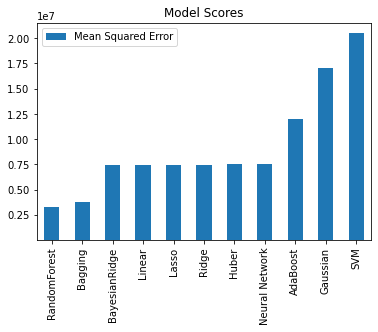

In [286]:
#logging.info("y_train and y_test assigined with RUL Value From The Train & Test Data set ")

def analyse_regression_models(train, labels):
    results = {}
    
    def test_model(clf):
        clf.fit(train,labels)
        y_pred=clf.predict(X_test)
        mse =mean_squared_error(y_pred,y_test)
        
        return mse
    
    clf = LinearRegression()
    results["Linear"] = test_model(clf)
    
    kernel = DotProduct() + WhiteKernel()
    clf = GaussianProcessRegressor(kernel = kernel ,random_state=0)
    results['Gaussian'] = test_model(clf)
    
    clf = Ridge()
    results["Ridge"] = test_model(clf)
    
    clf = BayesianRidge()
    results["BayesianRidge"] = test_model(clf)
    
    clf = HuberRegressor()
    results["Huber"] = test_model(clf)
    
    clf = Lasso()
    results["Lasso"] = test_model(clf)
    
    clf = MLPRegressor()
    results["Neural Network"] = test_model(clf)
    
    clf = BaggingRegressor()
    results["Bagging"] = test_model(clf)
    
    clf = RandomForestRegressor()
    results["RandomForest"] = test_model(clf)
    
    clf = AdaBoostRegressor()
    results["AdaBoost"] = test_model(clf)
    
    clf = SVR()
    results["SVM"] = test_model(clf)
    
    #logger
    logging.info("Find the best model for Regression which have lowest MSE")
    
    results = pd.DataFrame.from_dict(results, orient='index')
    results.columns = ["Mean Squared Error"] 
    results = results.sort_values(by=["Mean Squared Error"], ascending=True)
    results.plot(kind="bar", title="Model Scores")
    axes = plt.gca()
    axes.set_ylim([300, None])
    return results

analyse_regression_models(X_train, y_train)

RandomForest has the lowest MSE 

### Random Forest Regressor Model Training

In [287]:
# best HyperTune for RFR

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [288]:
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [289]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [290]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model,X_test , y_test)

Model Performance
Average Error: 1175.1029 degrees.
Accuracy = 87.12%.


In [291]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random,X_test , y_test)

Model Performance
Average Error: 1089.7908 degrees.
Accuracy = 87.70%.


In [294]:
# testing the best_random on pro_test_data 

best_random.score(pro_test_data.drop(['Price'],axis=1) , pro_test_data['Price'])

-4.801640139515948

In [296]:
pro_test_data_y_pred=best_random.predict(pro_test_data.drop(['Price'],axis=1))

C:\Users\alokc\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


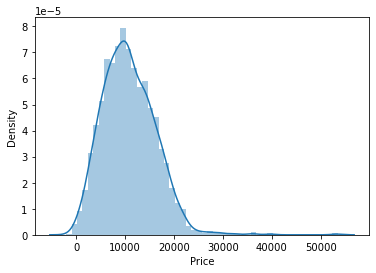

In [297]:
sns.distplot( pro_test_data['Price']-pro_test_data_y_pred)
plt.show()

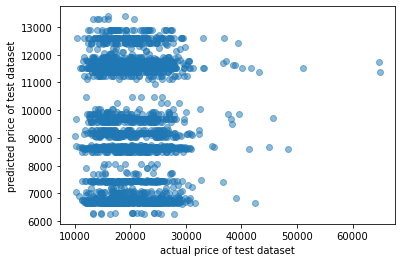

In [302]:
plt.scatter(pro_test_data['Price'],pro_test_data_y_pred, alpha = 0.5)
plt.xlabel("actual price of test dataset")
plt.ylabel("predicted price of test dataset")
plt.show()

C:\Users\alokc\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


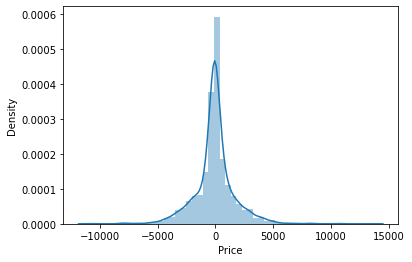

In [299]:
y_pred=best_random.predict(X_test)
sns.distplot(y_test-y_pred)
plt.show()